Benchmarking RMSF analysis speed using cloud & disk reading

Prerequisites:
- `write_benchmark_setup.ipynb`
- `align_setup.ipynb`

Steps:

1. Open a `zarr.Group` object from the aligned trajectory stored on disk
2. Open a group from the trajectory uploaded to an AWS S3 bucket
3. Create an `mda.Universe` object for both zarr groups and one for the original .xtc trajectory
4. Perform the RMSF analysis for each `mda.Universe`, time, and record results
5. Graph results

In [9]:
import zarrtraj
import MDAnalysis as mda
import zarr
from zarr.storage import LRUStoreCache
import s3fs
import os

# 1
yiipHDD = zarr.open_group("notebook_data_tmp/yiip_aligned.zarrtraj", mode='r')

# 2
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
BUCKET_NAME = os.getenv("BUCKET_NAME")

s3_fs = s3fs.S3FileSystem(
    # anon must be false to allow authentication
    anon=False,
    client_kwargs=dict(
        region_name='us-west-1',
    )
)
store = s3fs.S3Map(root=f'{BUCKET_NAME}/yiip_aligned.zarrtraj',
                  s3=s3_fs,
                  check=False)
# Select max_size value in bytes based on chunking of zarrtraj data
# At least one chunk must fit in the cache
cache = LRUStoreCache(store, max_size=10485760)
yiipS3 = zarr.open_group(store=cache, mode='r')

# 3
uHDD = mda.Universe("notebook_data_tmp/yiip_equilibrium/YiiP_system.pdb", yiipHDD)
uS3 = mda.Universe("notebook_data_tmp/yiip_equilibrium/YiiP_system.pdb", yiipS3)
uXTC = mda.Universe("notebook_data_tmp/yiip_equilibrium/YiiP_system.pdb", "notebook_data_tmp/yiip_aligned.xtc")

In [6]:
import time
from MDAnalysis.analysis import rms
import json

#4

universes = dict()
universes["uHDD"] = dict()
universes["uHDD"]["ref"] = uHDD
universes["uS3"] = dict()
universes["uS3"]["ref"] = uS3
universes["uXTC"] = dict()
universes["uXTC"]["ref"] = uXTC

for name in ("uHDD", "uS3", "uXTC"):
    c_alphas = universes[name]["ref"].select_atoms("protein and name CA")

    start = time.time()
    R = rms.RMSF(c_alphas).run()
    stop = time.time()

    universes[name]["RMSF_time"] = stop - start

rmsf_speeds = dict()
rmsf_speeds["uXTC"] = universes["uXTC"]["RMSF_time"]
rmsf_speeds["uS3"] = universes["uS3"]["RMSF_time"]
rmsf_speeds["uHDD"] = universes["uHDD"]["RMSF_time"]
with open('notebook_data_tmp/RMSF_speeds.json', 'w') as j:
    json.dump(rmsf_speeds, j)

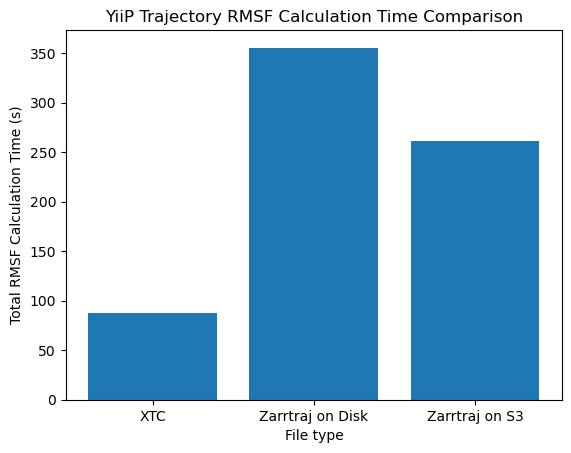

In [7]:
import matplotlib.pyplot as plt
import json

# 5. Graph performance.

with open('notebook_data_tmp/RMSF_speeds.json', 'r') as j:
    data = json.load(j)

time_vals = [data["uXTC"], data["uHDD"], data["uS3"]]
filenames = ["XTC", "Zarrtraj on Disk", "Zarrtraj on S3"]

plt.bar(filenames, time_vals)
plt.title('YiiP Trajectory RMSF Calculation Time Comparison')
plt.xlabel('File type')
plt.ylabel('Total RMSF Calculation Time (s)')

plt.savefig("RMSF_speeds.svg", format='svg')
plt.show()